In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.schema import MetaData

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# inpsecting engine to verify connection pool to right DB,also ...
#we check tables names ... do not have to ...
#inspector=inspect(engine)
#tablrinspector.get_table_names()

In [7]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
Base.metadata.tables # knowing tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [10]:
# Save references to each table
Measurement,Station=Base.classes.measurement, Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# are stations near by?
stations=session.query(Station.station,Station.longitude,Station.latitude).all()
stations

[('USC00519397', -157.8168, 21.2716),
 ('USC00513117', -157.8015, 21.4234),
 ('USC00514830', -157.8374, 21.5213),
 ('USC00517948', -157.9751, 21.3934),
 ('USC00518838', -158.0111, 21.4992),
 ('USC00519523', -157.71139, 21.33556),
 ('USC00519281', -157.84888999999998, 21.45167),
 ('USC00511918', -157.9992, 21.3152),
 ('USC00516128', -157.8025, 21.3331)]

In [13]:
# Find the most recent date in the data set.
myquery=session.query(Measurement.date).\
        order_by(Measurement.date.desc()).\
        first()
latest_date=myquery[0]
latest_date # debug print

'2017-08-23'

In [14]:
# Design a query to retrieve the last 12 months of precipitation data 
# and plot the results.
# Starting from the most recent data point in the database.
latest_date=dt.date.fromisoformat(latest_date)

In [15]:
# Calculate the date one year from the last date in data set.
start_date=latest_date-dt.timedelta(days=365)
start_date=start_date.isoformat()
start_date

'2016-08-23'

In [16]:
# Perform a query to retrieve the data and precipitation scores
myquery=session.query(Measurement.date,Measurement.prcp,Measurement.station).\
        filter(Measurement.date>=start_date).order_by(Measurement.date).all()
myquery # debug print

[('2016-08-23', 0.0, 'USC00519397'),
 ('2016-08-23', 0.15, 'USC00513117'),
 ('2016-08-23', 0.05, 'USC00514830'),
 ('2016-08-23', None, 'USC00517948'),
 ('2016-08-23', 0.02, 'USC00519523'),
 ('2016-08-23', 1.79, 'USC00519281'),
 ('2016-08-23', 0.7, 'USC00516128'),
 ('2016-08-24', 0.08, 'USC00519397'),
 ('2016-08-24', 2.15, 'USC00513117'),
 ('2016-08-24', 2.28, 'USC00514830'),
 ('2016-08-24', None, 'USC00517948'),
 ('2016-08-24', 1.22, 'USC00519523'),
 ('2016-08-24', 2.15, 'USC00519281'),
 ('2016-08-24', 1.45, 'USC00516128'),
 ('2016-08-25', 0.08, 'USC00519397'),
 ('2016-08-25', 0.08, 'USC00513117'),
 ('2016-08-25', 0.0, 'USC00514830'),
 ('2016-08-25', 0.0, 'USC00517948'),
 ('2016-08-25', 0.21, 'USC00519523'),
 ('2016-08-25', 0.06, 'USC00519281'),
 ('2016-08-25', 0.11, 'USC00516128'),
 ('2016-08-26', 0.0, 'USC00519397'),
 ('2016-08-26', 0.03, 'USC00513117'),
 ('2016-08-26', 0.02, 'USC00514830'),
 ('2016-08-26', 0.04, 'USC00517948'),
 ('2016-08-26', 0.0, 'USC00519523'),
 ('2016-08-26', 0.

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# since we need date as index - it has to be unique?  so - 
# group by date and taking average precipitation across all stations
# Sort the dataframe by date - taken care by groupby
myquery=session.query(Measurement.date,func.avg(Measurement.prcp).label('Average Precipitation')).\
        filter(Measurement.date>=start_date).group_by(Measurement.date).all()
my_df=pd.DataFrame(myquery).set_index('date')


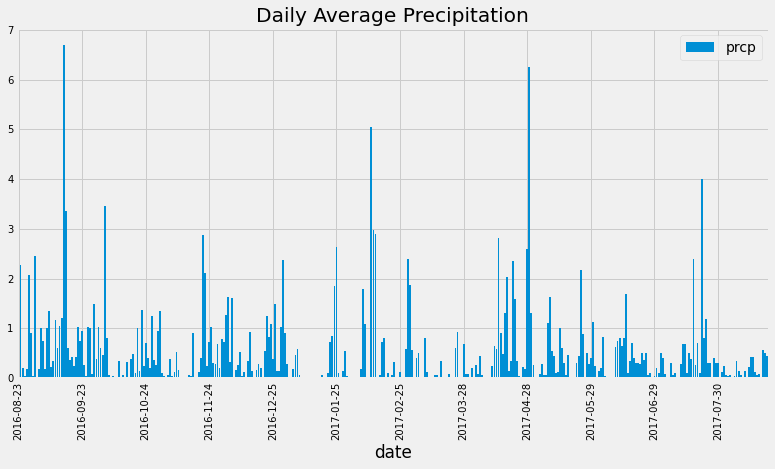

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plot1=my_df.plot.bar(title='Daily Average Precipitation',
                         rot=90,
                         width=0.9 )
plt.yticks(fontsize=10)    
plt.xticks(range(0,370,31),fontsize=10)
plt.savefig('../Images/daily_average_prcp.png')

In [19]:
# ok... to repeat example with all stations in query and non unique index ???
# Perform a query to retrieve the data and precipitation scores
myquery=session.query(Measurement.date,Measurement.prcp).\
        filter(Measurement.prcp!=None,Measurement.date>=start_date).order_by(Measurement.date).all()
my_df=pd.DataFrame(myquery).set_index('date')
my_df # debug print
my_df.isnull().sum()

prcp    0
dtype: int64

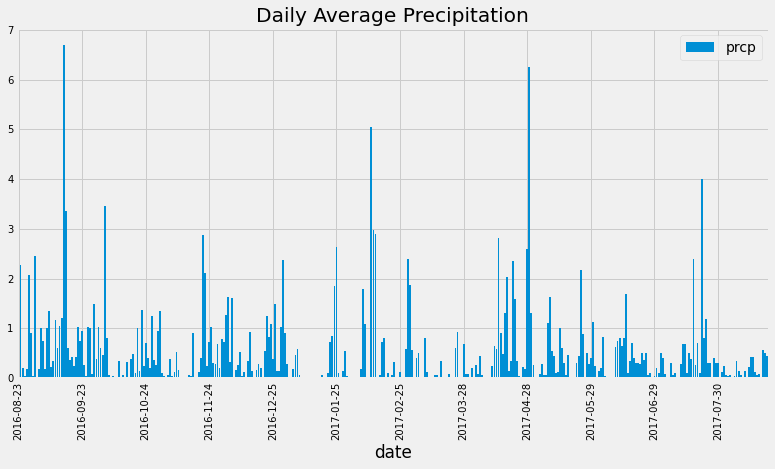

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plot1=my_df.plot.bar(title='Daily Average Precipitation',
                         rot=90,
                         width=0.9 )
plt.yticks(fontsize=10)    
plt.xticks(range(0,370,31),fontsize=10)
plt.savefig('../Images/daily_prcp.png')

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
my_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(func.count(Station.id)).scalar()
print(f'Total Number of Weather Stations = {total_stations}')


Total Number of Weather Stations = 9


In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station, func.count(Measurement.station).label("Activity_count")).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# same as above but with station ID , aslo trying subquery method
active_station_id=session.query(\
        Station.id,Station.station,\
        func.count(Station.station).label('activity_count')).\
        join(Measurement, Measurement.station==Station.station).\
        group_by(Station.station).order_by(func.count(Station.station).desc()).\
       subquery()
    
session.query(active_station_id).all()

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [31]:
# getting most active station id
query=session.query(active_station_id.c.id).first()
most_active_id=query[0]
print(f'Most Active Weather Station ID = {most_active_id}')

Most Active Weather Station ID = 7


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# create subquery temperature data- join Station and Measurement tables 
temp_join=session.query(Station.id,Station.station,\
    Measurement.date,Measurement.tobs).\
    join(Station,Station.station==Measurement.station).\
    subquery()
session.query(temp_join).limit(10).all() # debug print

[(1, 'USC00519397', '2010-01-01', 65.0),
 (1, 'USC00519397', '2010-01-02', 63.0),
 (1, 'USC00519397', '2010-01-03', 74.0),
 (1, 'USC00519397', '2010-01-04', 76.0),
 (1, 'USC00519397', '2010-01-06', 73.0),
 (1, 'USC00519397', '2010-01-07', 70.0),
 (1, 'USC00519397', '2010-01-08', 64.0),
 (1, 'USC00519397', '2010-01-09', 68.0),
 (1, 'USC00519397', '2010-01-10', 73.0),
 (1, 'USC00519397', '2010-01-11', 64.0)]

In [33]:
#  getting max - min - avg  from one query
query=session.query(temp_join.c.id,\
              func.min(temp_join.c.tobs).label('min_temp'),\
              func.max(temp_join.c.tobs).label('max_temp'),\
              func.round(func.avg(temp_join.c.tobs),1).label('avg_temp')).\
              filter(temp_join.c.id==most_active_id).one()
print(f'\nmostactive station = {query[0]},min temp = {query[1]}, max temp = {query[2]}, avg temp = {query[3]}' )

#  getting max - min - avg  from one query for each temp
min_temp=session.query(func.min(temp_join.c.tobs)).\
    filter(temp_join.c.id==most_active_id).scalar()
print(f'min temp={min_temp}')
max_temp=session.query(func.max(temp_join.c.tobs)).\
    filter(temp_join.c.id==most_active_id).scalar()
print(f'max temp={max_temp}')
avg_temp=session.query(func.round(func.avg(temp_join.c.tobs),1)).\
              filter(temp_join.c.id==most_active_id).scalar()
print(f'avg temp={avg_temp}')


mostactive station = 7,min temp = 54.0, max temp = 85.0, avg temp = 71.7
min temp=54.0
max temp=85.0
avg temp=71.7


In [34]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query=session.query(temp_join.c.date,\
                    temp_join.c.tobs).\
            filter(temp_join.c.id==most_active_id,\
                     temp_join.c.tobs!=None,\
                     temp_join.c.date>=start_date)\
            .all()
query # debug Print

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

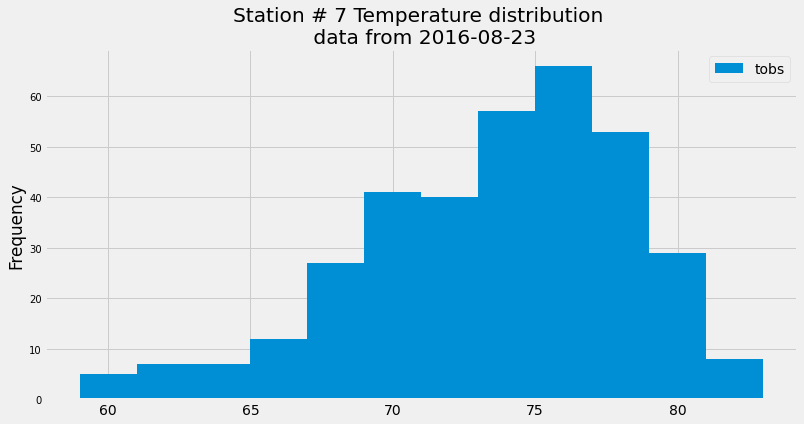

In [36]:
#Moving query to DataFrame 
my_df=pd.DataFrame(query).set_index('date')
# Use Pandas Plotting with Matplotlib to plot the data
plot1=my_df.plot.hist(title=f'Station # {most_active_id} Temperature distribution \n data from {start_date}'  ,
                      bins=12)
plt.yticks(fontsize=10)    
plt.savefig('../Images/temp_his.png')

# Close session

In [37]:
# Close Session
session.close()